In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# All skl imports go here
from sklearn import tree   # Decision Trees
from sklearn import svm    # svm
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import sklearn as skl

# Data Loading

In [2]:
NUM_CLASSES = 6
CLASSES = ["sadnesss", "joy", "love", "anger", "fear"]

In [14]:
# Load all data
train_data = pd.read_csv("data/training_labse.csv")
test_data = pd.read_csv("data/test_labse.csv")
validation_data = pd.read_csv("data/validation_labse.csv")

# Separate X's and y's from each other
FEATURE_COLUMNS = [x for x in train_data if x.startswith("_e")]
LABEL_COLUMN = "label"

X_train = train_data[FEATURE_COLUMNS]
Y_train = train_data[LABEL_COLUMN]

X_test = test_data[FEATURE_COLUMNS]
Y_test = test_data[LABEL_COLUMN]

X_val = validation_data[FEATURE_COLUMNS]
Y_val = validation_data[LABEL_COLUMN]

# These are used to run cross validation
X_train_val = pd.concat([X_train, X_val]) 
Y_train_val = pd.concat([Y_train, Y_test])

# These are used to run val and test for Neural Nets
X_val_test = pd.concat([X_val, X_test])
Y_val_test = pd.concat([Y_val, Y_test])

In [15]:
# Perform pre-processing PCA on the training set
def perform_pca(dataset, target_variance):
    pca = PCA(n_components= target_variance)

    # Need to standardize the data frirst
    standardized = (dataset - dataset.mean(axis=0)) / dataset.std(axis = 0)

    pca.fit(X=standardized)
    dataset_reduced = pca.fit_transform(X=standardized)

    return pca, dataset_reduced



In [31]:
TARGET_EXPLAINED_VARIANCE = 2

pca_train, X_train_reduced = perform_pca(X_train, TARGET_EXPLAINED_VARIANCE)
pca_tran_val, X_train_val_reduced = perform_pca(X_train_val, TARGET_EXPLAINED_VARIANCE)
pca_val_test, X_val_test_reduced = perform_pca(X_val_test, TARGET_EXPLAINED_VARIANCE)

print(f"{pca_train.n_components_} components for training")

2 components for training


# K-Folds Cross Validation

In [6]:

def k_folds_x_val(model): 
    cumulative_accuracy = 0
    cumulative_kappa = 0

    k_folds = KFold(n_splits=10)

    for i, (train_index, test_index) in enumerate(k_folds.split(X_train_val_reduced, Y_train_val)):
        model.fit(X_train_val_reduced[train_index], Y_train_val.iloc[train_index])
        
        Y_pred = model.predict(X_train_val_reduced[test_index])
        Y_true = Y_train_val.iloc[test_index]
        # Add all metrics here

        cumulative_accuracy += metrics.accuracy_score(Y_true, Y_pred)
        cumulative_kappa += metrics.cohen_kappa_score(Y_true, Y_pred)

    folds = k_folds.get_n_splits()
    print(f"Performed {folds}-fold cross validation")
    print(f"Average accuracy {cumulative_accuracy / folds}")
    print(f"Average Kappa {cumulative_kappa / folds}")


# Grid Search Hyperparameter Optimization

In [33]:
def objective(model):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return metrics.accuracy_score(Y_test, Y_pred)

def gridSearchHPO(model, search_space):
    grid_search = GridSearchCV(estimator=model, 
                                param_grid=search_space, 
                                scoring=objective,
                                cv=5,
                                n_jobs=-1) # -1 means max amount
    grid_search.fit(X_train, Y_train)
    return grid_search

# Decision Trees

In [8]:
decision_tree_model = tree.DecisionTreeClassifier(
    criterion='entropy', 
    splitter = 'best',
    max_depth = 5
)

In [9]:
k_folds_x_val(decision_tree_model)

Performed 10-fold cross validation
Average accuracy 0.46338888888888896
Average Kappa 0.22733008013902026


In [34]:
# ['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 
# 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter']
gridsearch = gridSearchHPO(decision_tree_model, search_space={'max_depth':[8, 32, 64, None], 'max_features':[8, 32, 128, 512], 'min_samples_leaf':[1, 2, 3], 'min_samples_split':[16, 64, 256]})

c:\Users\techt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [35]:
gridsearch.best_params_

{'max_depth': 8,
 'max_features': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 16}

[Text(0.5, 0.9166666666666666, 'x[2] <= -0.23\nentropy = 2.272\nsamples = 16000\nvalue = [4666, 5362, 1304, 2159, 1937, 572]'),
 Text(0.25, 0.75, 'x[3] <= -0.747\nentropy = 2.131\nsamples = 7717\nvalue = [1531, 3666, 810, 711, 677, 322]'),
 Text(0.125, 0.5833333333333334, 'x[5] <= 2.122\nentropy = 2.287\nsamples = 3484\nvalue = [1079, 1070, 249, 495, 451, 140]'),
 Text(0.0625, 0.4166666666666667, 'x[0] <= -6.003\nentropy = 2.299\nsamples = 2709\nvalue = [940, 653, 169, 436, 394, 117]'),
 Text(0.03125, 0.25, 'x[15] <= 0.01\nentropy = 2.051\nsamples = 981\nvalue = [470, 77, 35, 196, 163, 40]'),
 Text(0.015625, 0.08333333333333333, 'entropy = 2.161\nsamples = 413\nvalue = [147, 33, 10, 80, 120, 23]'),
 Text(0.046875, 0.08333333333333333, 'entropy = 1.849\nsamples = 568\nvalue = [323, 44, 25, 116, 43, 17]'),
 Text(0.09375, 0.25, 'x[2] <= -2.854\nentropy = 2.309\nsamples = 1728\nvalue = [470, 576, 134, 240, 231, 77]'),
 Text(0.078125, 0.08333333333333333, 'entropy = 2.225\nsamples = 869\nva

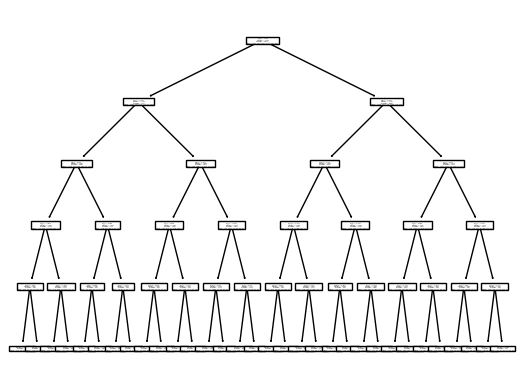

In [10]:
decision_tree_model.fit(X_train_reduced, Y_train)
tree.plot_tree(decision_tree_model)

# SVMs

In [11]:
svm_classifier = svm.SVC(kernel='sigmoid') # 'precomputed', 'linear', 'poly', 'sigmoid', 'rbf'

#Train the model using the training sets
svm_classifier.fit(X_train_reduced, Y_train)

#Predict the response for test dataset
k_folds_x_val(svm_classifier)

Performed 10-fold cross validation
Average accuracy 0.5808888888888889
Average Kappa 0.4227651194469132


# Pytorch Setup

In [37]:
# Pytorch specific constants
from torch.utils.data import TensorDataset, DataLoader
from utils.neuralnet import NeuralNetwork
from utils.trainer import training_loop, evaluate
import torch

BATCH_SIZE = 32
LEARNING_RATE = 1e-3

In [32]:
# For pytorch specifically we should load data to the provided dataloader and dataset classes. 
# This handles the batching for us.

pt_train_set = TensorDataset(torch.Tensor(X_train_reduced), torch.Tensor(Y_train.to_numpy()).long())
pt_val_set = TensorDataset(torch.Tensor(pca_train.transform(X_val)), torch.Tensor(Y_val.to_numpy()).long())
pt_test_set = TensorDataset(torch.Tensor(pca_train.transform(X_test)), torch.Tensor(Y_test.to_numpy()).long())
pt_val_test_set = TensorDataset(torch.Tensor(pca_train.transform(X_val_test)), torch.Tensor(Y_val_test.to_numpy()).long())

pt_train_loader = DataLoader(
                    dataset=pt_train_set, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                )
pt_val_loader = DataLoader(
                    dataset=pt_val_set, 
                    batch_size=1, 
                    shuffle=True,
                )
pt_test_loader = DataLoader(
                    dataset=pt_test_set, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                )

pt_val_test_loader = DataLoader(
                    dataset=pt_val_test_set, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                )

# MLP

In [35]:
# Initialize neural network
mlp = NeuralNetwork(X_train_reduced.shape[1], [], NUM_CLASSES)

training_loop(mlp, pt_train_loader, pt_val_loader, 10, LEARNING_RATE)

Epoch 1
train_loss = 1.7944, val_loss = 1.7087
Epoch 2
train_loss = 1.6434, val_loss = 1.6303
Epoch 3
train_loss = 1.7509, val_loss = 1.6006
Epoch 4
train_loss = 1.4816, val_loss = 1.5881
Epoch 5
train_loss = 1.6314, val_loss = 1.5830
Epoch 6
train_loss = 1.6926, val_loss = 1.5813
Epoch 7
train_loss = 1.4808, val_loss = 1.5803
Epoch 8
train_loss = 1.4880, val_loss = 1.5798
Epoch 9
train_loss = 1.6461, val_loss = 1.5793
Epoch 10
train_loss = 1.5183, val_loss = 1.5796


In [38]:
evaluate(model=mlp, val_dl=pt_test_loader)

loss = 1.5599


# RNN

# Encoder-Only Transformer